In [9]:
from skimage.io import imread_collection
import cv2
import numpy as np
from keras.utils import np_utils 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_data(path, size):
    #creating a collection with the available images
    image = imread_collection(path)
    image_set = []
    for n in image:
        n = cv2.cvtColor(n,cv2.COLOR_RGB2GRAY)
        n = cv2.resize(n,(size,size))
        n = n / 255
        image_set.append(n)
    return image_set
    
def set_init(dataset, train_set_ratio, valid_set_ratio, test_set_ratio):

    
    #creating label set for all images
    label = np.empty(195*4)
    for i in range(195):
        label[i*4:i*4+4] = i
    label = label.astype(np.int)
    label = np_utils.to_categorical(label, 195)#transfer to one-hot matrix
    
    train_num = 780*train_set_ratio
    train_num = int(train_num)
    valid_num = 780*valid_set_ratio
    valid_num = int(valid_num)
    test_num = 780*test_set_ratio
    test_num = int(test_num)
    
    train_data = np.empty((train_num,200,200))  
    train_label = np.empty((train_num,195))   
    valid_data = np.empty((valid_num, 200,200))   
    valid_label = np.empty((valid_num,195))   
    test_data = np.empty((test_num,200,200))  
    test_label = np.empty((test_num,195)) 
    
    x_test_tot = np.empty((valid_num + test_num,200,200))
    y_test_tot = np.empty((valid_num + test_num,195))
    
    train_data, x_test_tot, train_label, y_test_tot = train_test_split(dataset, label, test_size = 1-train_set_ratio,stratify=label)
    
    valid_data, test_data, valid_label, test_label = train_test_split(x_test_tot, y_test_tot, test_size = test_set_ratio/(valid_set_ratio + test_set_ratio),stratify=y_test_tot)
    
    train_data = np.asarray(train_data)
    valid_data = np.asarray(valid_data)
    test_data = np.asarray(test_data)
#     for i in range(195):
#         train_data[i * 2:i * 2 + 2] = image_set[i * 4:i * 4 + 2]
#         train_label[i * 2:i * 2 + 2] = label[i * 4:i * 4 + 2]
#         valid_data[i] = image_set[i * 4 + 2]
#         valid_label[i] = label[i * 4 + 2]
#         test_data[i] = image_set[i * 4 + 3]
#         test_label[i] = label[i * 4 + 3]
    result = [(train_data, train_label), (valid_data, valid_label),(test_data, test_label)]
   
    return result

In [10]:
data_set = load_data('original/*.jpg',200)

In [12]:
print((data_set[0].shape))
data = set_init(data_set, 0.5, 0.25, 0.25)
print(len(data[0][0]))
print(len(data[0][0][0]))
print(data[0][0][0].shape)
print(type(data[0][0]))

(200, 200)
390
200
(200, 200)
<class 'numpy.ndarray'>


In [55]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

def train(data, batch_size, epochs, nb_filters, pool_size, kernel_size):
    np.random.seed(1337)  # for reproducibility
    img_rows, img_cols = 200, 200  # 输入图片样本的宽高
    nb_classes = 195  # 分类数目
    input_shape = (img_rows, img_cols,1)  # 输入图片的维度

    [(X_train, Y_train), (X_valid, Y_valid),(X_test, Y_test)] = data
    print(X_train[0].shape)
    X_train = X_train[:,:,:,np.newaxis]  # 添加一个维度，代表图片通道。这样数据集共4个维度，样本个数、宽度、高度、通道数
    X_valid=X_valid[:,:,:,np.newaxis]  # 添加一个维度，代表图片通道。这样数据集共4个维度，样本个数、宽度、高度、通道数
    X_test=X_test[:,:,:,np.newaxis]  # 添加一个维度，代表图片通道。这样数据集共4个维度，样本个数、宽度、高度、通道数
    print('样本数据集的维度：', X_train.shape,Y_train.shape)
    print('测试数据集的维度：', X_test.shape,Y_test.shape)
    model = Sequential()
    model.add(Conv2D(6,kernel_size,input_shape=input_shape,strides=1))  # 卷积层1
    model.add(AveragePooling2D(pool_size,strides=2))  # 池化层
    #model.add(Conv2D(12,kernel_size,strides=1))  # 卷积层2
    #model.add(AveragePooling2D(pool_size,strides=2))  # 池化层
    model.add(Flatten())  # 拉成一维数据
    model.add(Dense(nb_classes))  # 全连接层2
    model.add(Activation('sigmoid'))  # sigmoid评分

    # 编译模型
    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    # 训练模型
   # model.fit(X_train, Y_train, batch_size, epochs,verbose=1, validation_data=(X_valid, Y_valid))
    img_generator = ImageDataGenerator(zoom_range = 0.3)
    test_datagen = ImageDataGenerator(zoom_range = 0.3)
    vaild_generator = test_datagen.flow(X_valid,Y_valid,batch_size = batch_size)
    model.fit_generator(img_generator.flow
    (X_train, Y_train, batch_size = batch_size),steps_per_epoch=len(X_train)// batch_size,epochs = epochs , verbose = 1, 
                        validation_data=(vaild_generator),validation_steps = len(X_valid)// batch_size)
    
    # 评估模型
    
    
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    
    
    
    y_train_out = model.predict(X_train)
    y_train_out = y_train_out.argmax(axis=1)
    for i in range(len(y_train_out)):
    #     oneimg = X_test[i,:,:,0]*256
    #     im = Image.fromarray(oneimg)
    #     im.show()
        print('train: 第%d个人识别为第%d个人'%(Y_train.argmax(axis=1).item(i),y_train_out[i]))
        

    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=1)   # 获取概率最大的分类，获取每行最大值所在的列
    for i in range(len(y_pred)):
    #     oneimg = X_test[i,:,:,0]*256
    #     im = Image.fromarray(oneimg)
    #     im.show()
        print('第%d个人识别为第%d个人'%(i,y_pred[i]))

In [ ]:
train(data, 100, 20, 64, 4, 10)

(200, 200)
样本数据集的维度： (390, 200, 200, 1) (390, 195)
测试数据集的维度： (195, 200, 200, 1) (195, 195)
Epoch 1/20


(200, 200)


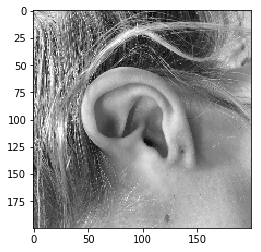

In [53]:


image = set1[0]
print(set1[0].shape)

# plt.imshow(image)
# plt.show()

plt.imshow(image, cmap='gray')
plt.show()

In [4]:
print(image.shape)

(3024, 4032)


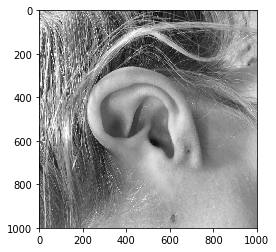

[[173 179 179 ... 181 183 183]
 [204 177 189 ... 176 184 184]
 [227 204 197 ... 172 171 171]
 ...
 [110  92 115 ... 135 143 140]
 [ 98  86 123 ... 135 139 144]
 [ 99  98 133 ... 135 134 149]]
(1000, 1000)


In [5]:
resized_image = cv2.resize(image, (1000,1000 ))
plt.imshow(resized_image, cmap='gray')
plt.show()
print(resized_image)
print(resized_image.shape)

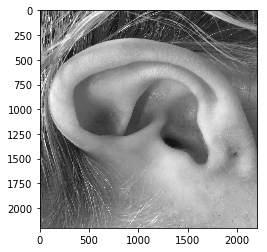

[[122 124 126 ...  87  87  87]
 [128 130 133 ...  84  84  84]
 [135 137 139 ...  81  81  81]
 ...
 [122 126 133 ... 188 188 188]
 [126 130 136 ... 188 188 188]
 [129 133 139 ... 188 188 188]]
(2200, 2200)


In [16]:
crop_img = image[500:2700,800:3000]
plt.imshow(crop_img, cmap='gray')
plt.show()
print(crop_img)
print(crop_img.shape)


In [17]:
for ear in train_x1:
    ear = cv2.cvtColor(ear,cv2.COLOR_RGB2GRAY)

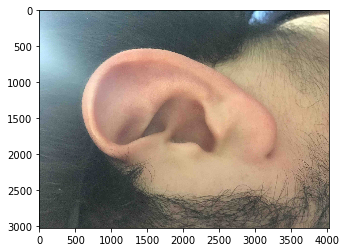

(3024, 4032, 3)


In [19]:
plt.imshow(train_x1[145],cmap = 'gray')
plt.show()
print(train_x1[145].shape)